I TRIED DATA FETCH FROM THE API BUT I NOT GETTING SATISFYING RESULT SO I DECIDED TO EXTRACT THE MDA SECTION MANUALLY FROM 10K AND 10Q FILING

In [ ]:
!pip install sec-edgar-downloader

# data extraction from SEC website

In [ ]:
# from sec_edgar_downloader import Downloader
# import os

# # --- 1. Configuration ---
# # REQUIRED: Change this to your name and email address to comply with SEC rules.
# YOUR_COMPANY_NAME = "My University Project"
# YOUR_EMAIL = "komndra25302@iiitnr.edu.in"

# TICKER = "AAPL"
# FORMS_TO_DOWNLOAD = ["10-K", "10-Q"]
# START_DATE = "2000-01-01"
# END_DATE = "2025-09-30" # Adjust to current date if needed

# DOWNLOAD_DIR = "sec_filings_raw"

# print(f"Starting download of {TICKER} {FORMS_TO_DOWNLOAD} filings from {START_DATE} to {END_DATE}...")

# try:
#     # Initialize Downloader
#     # The downloader will create the directory structure: sec_filings_raw/sec-edgar-data/320193/10-K/...
#     dl = Downloader(YOUR_COMPANY_NAME, YOUR_EMAIL, DOWNLOAD_DIR)

#     # Download 10-K Filings
#     dl.get(
#         FORMS_TO_DOWNLOAD[0],
#         TICKER,
#         after=START_DATE,
#         before=END_DATE,
#         download_details=True # This ensures we get the document files, not just the index file
#     )

#     # Download 10-Q Filings
#     dl.get(
#         FORMS_TO_DOWNLOAD[1],
#         TICKER,
#         after=START_DATE,
#         before=END_DATE,
#         download_details=True
#     )

#     print("\n✅ Download Complete!")
#     print(f"Filings saved locally in the folder: {os.path.abspath(DOWNLOAD_DIR)}")

# except Exception as e:
#     print(f"An error occurred during download: {e}")

# # This script only downloads; the next step is to process the files.

# download the folder locally

In [ ]:
# import shutil
# from google.colab import files

# # Replace 'my_folder' with your folder name
# shutil.make_archive("sec_filings_raw", 'zip', "sec_filings_raw")

# # Download the zip file
# files.download("sec_filings_raw.zip")


# it remove unnccessory thing from paragraph so that i can put in to a single cell

In [ ]:
raw_mda_text ="""  copy paste content from the mda section"""

In [ ]:
import re

def clean_paragraph_for_excel(raw_paragraph):
    """
    Cleans a block of text (paragraph) by removing line breaks and normalizing
    whitespace, ensuring it fits into a single Excel cell without spreading.

    Args:
        raw_paragraph (str): The multi-line text you want to clean.

    Returns:
        str: A single-line string, ready for CSV/Excel.
    """

    if not isinstance(raw_paragraph, str):
        # Handle cases where input might not be a string (e.g., None or NaN)
        return ""

    # --- Step 1: Remove Newline/Line Feed Characters ---
    # This is the CRITICAL step to prevent Excel from spreading text across rows.
    # Replace all \n (Unix) and \r (Windows/Mac) line breaks with a single space.
    cleaned_text = raw_paragraph.replace('\n', ' ').replace('\r', ' ')

    # --- Step 2: Normalize White Space ---
    # This step removes redundant spaces (e.g., if there were two line breaks
    # in a row, it ensures they don't become multiple spaces).
    # We use regex here to replace any sequence of one or more whitespace
    # characters (\s+) with a single space (' ').
    normalized_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    return normalized_text

# ====================================================================
# EXAMPLE USAGE
# ====================================================================

# This simulates a raw MDA text block read from a file.


# 1. Apply the cleaning function
clean_mda = clean_paragraph_for_excel(raw_mda_text)

# 2. Print the results to see the transformation
print("--- Original Text (Multi-line) ---")
print(raw_mda_text)

print("\n--- Cleaned Text (Single-line for Excel Cell) ---")
print(f"'{clean_mda}'")

--- Original Text (Multi-line) ---

Item 7.
Management’s Discussion and Analysis of Financial Condition and Results of Operations
This section and other parts of this Annual Report on Form 10-K (“Form 10-K”) contain forward-looking statements, within the meaning of the Private Securities Litigation Reform Act of 1995, that involve risks and uncertainties. Forward-looking statements provide current expectations of future events based on certain assumptions and include any statement that does not directly relate to any historical or current fact. Forward-looking statements can also be identified by words such as “future,” “anticipates,” “believes,” “estimates,” “expects,” “intends,” “plans,” “predicts,” “will,” “would,” “could,” “can,” “may,” and similar terms. Forward-looking statements are not guarantees of future performance and the Company’s actual results may differ significantly from the results discussed in the forward-looking statements. Factors that might cause such differences 

# hyperlink extraction from excel file

In [ ]:
pip install pandas openpyxl

In [ ]:
import pandas as pd
from openpyxl import load_workbook
import os

# --- Configuration ---
# NOTE: Replace this with the actual path to your Excel file
INPUT_EXCEL_FILE = 'aapl_sec_filings.xlsx'
OUTPUT_CSV_FILE = 'filings_with_hyperlinks.csv'
SHEET_NAME = 0 # Use 0 for the first sheet, or provide the actual sheet name (e.g., 'Sheet1')

# --- 1. Load the Workbook with openpyxl ---
try:
    # Load the workbook and select the sheet
    workbook = load_workbook(INPUT_EXCEL_FILE)
    sheet = workbook.worksheets[SHEET_NAME]
except FileNotFoundError:
    print(f"ERROR: File not found at '{INPUT_EXCEL_FILE}'. Please check the file name and path.")
    exit()
except Exception as e:
    print(f"An error occurred while loading the Excel file: {e}")
    exit()

# --- 2. Iterate and Extract Data ---

# We need to manually get the header row first to know the original column names
header = [cell.value for cell in sheet[1]]

# Find the index of the column containing the links (assuming it's the first column, index 0)
link_column_index = 0 # A=0, B=1, C=2...

# List to hold the row data (including the extracted hyperlink)
data_list = []

# Start iterating from the second row (skipping the header row)
print(f"Starting extraction from sheet '{sheet.title}'...")

for row_index, row in enumerate(sheet.iter_rows(min_row=2)):
    row_data = {}
    extracted_link = None

    for col_index, cell in enumerate(row):
        # Store the cell value in the dictionary, using the header name as the key
        row_data[header[col_index]] = cell.value

        # Check the specified link column for a hyperlink
        if col_index == link_column_index:
            # openpyxl stores the hyperlink URL in the 'hyperlink' attribute
            if cell.hyperlink and cell.hyperlink.target:
                extracted_link = cell.hyperlink.target
            # If the hyperlink is missing, sometimes the link is just the text value (unlikely here)
            elif cell.value and ('http' in str(cell.value)):
                extracted_link = str(cell.value)

    # Add the extracted link to the row data under a new column name
    row_data['SEC_URL'] = extracted_link

    data_list.append(row_data)

    if (row_index + 1) % 50 == 0:
        print(f"Processed {row_index + 1} rows...")

# --- 3. Create DataFrame and Save ---

df_links = pd.DataFrame(data_list)

# Save the final dataset to a CSV file (easier for collaboration and processing than Excel)
df_links.to_csv(OUTPUT_CSV_FILE, index=False)

print("\n=======================================================")
print("✅ Hyperlink Extraction Complete!")
print(f"The extracted links have been saved to: {OUTPUT_CSV_FILE}")
print("=======================================================")
print(df_links[['SEC_URL']].head())

# Optional: If you need it back in Excel format (though CSV is better for our project):
# df_links.to_excel("filings_with_hyperlinks.xlsx", index=False)

Starting extraction from sheet 'Sheet1'...
Processed 50 rows...
Processed 100 rows...

✅ Hyperlink Extraction Complete!
The extracted links have been saved to: filings_with_hyperlinks.csv
                                             SEC_URL
0                                               None
1  https://www.sec.gov/Archives/edgar/data/320193...
2  https://www.sec.gov/Archives/edgar/data/320193...
3  https://www.sec.gov/Archives/edgar/data/320193...
4  https://www.sec.gov/Archives/edgar/data/320193...


# MDA EXTRACTION FROM THE LINK

In [ ]:
import pandas as pd

# Read the Excel file
df = pd.read_excel('/content/aapl_sec_filings.xlsx')

# Set the first row as the header
df.columns = df.iloc[0]

# Drop the first row which is now the header
df = df[1:].reset_index(drop=True)

# Drop the column that is entirely NaN
df = df.dropna(axis=1, how='all')

# Drop rows where the 'MDA' column is NaN
df = df.dropna(subset=['MDA'])

# Display the updated DataFrame
display(df.tail())

,Form & File,Filed ↓,Reporting for,Filing entity/person,MDA
31,10-K (Annual report),2017-11-03 00:00:00,2017-09-30 00:00:00,APPLE INC (AAPL),Item 7. Management’s Discussion and Analysis o...
32,10-Q (Quarterly report),2017-08-02 00:00:00,2017-07-01 00:00:00,APPLE INC (AAPL),'Item 2. Management’s Discussion and Analysis ...
33,10-Q (Quarterly report),2017-05-03 00:00:00,2017-04-01 00:00:00,APPLE INC (AAPL),'Item 2. Management’s Discussion and Analysis ...
34,10-Q (Quarterly report),2017-02-01 00:00:00,2016-12-31 00:00:00,APPLE INC (AAPL),Item 2. Management’s Discussion and Analysis o...
35,10-K (Annual report),2016-10-26 00:00:00,2016-09-24 00:00:00,APPLE INC (AAPL),Item 7. Management’s Discussion and Analysis o...


In [ ]:
# # Save the cleaned DataFrame to a CSV file
# df.to_csv('aapl_sec_filings_7year.csv', index=False)

# print("Cleaned dataset saved to 'aapl_sec_filings_7year.csv'")

I have saved the cleaned dataset to `cleaned_aapl_sec_filings.csv`. You can download this file from the files pane on the left.

Would you like to perform any further analysis on this data? For example, we could look at:

*   **Trends in filings over time:** Analyze the frequency of 10-K and 10-Q filings per year.
*   **Length of MDA sections:** Calculate the length of the "MDA" column to see how detailed these sections are over time.
*   **Specific keywords:** Search the "MDA" column for specific terms related to risks, opportunities, or financial performance.

In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download necessary NLTK data (if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab') # Download punkt_tab resource


# Define a text cleaning function
def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Join tokens back into a string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

# Apply the preprocessing function to the 'MDA' column
df['Preprocessed Text'] = df['MDA'].apply(preprocess_text)

# Display the DataFrame with the new column
display(df[['MDA', 'Preprocessed Text']].head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,MDA,Preprocessed Text
0,the company's discussion and analysis of its f...,companys discussion analysis financial conditi...
1,Item 2. Management’s Discussion and Analysis o...,item management ’ discussion analysis financia...
2,Item 2. Management’s Discussion and Analysis o...,item management ’ discussion analysis financia...
3,Item 7. Management’s Discussion and Analysis o...,item management ’ discussion analysis financia...
4,'Item 2. Management’s Discussion and Analysis ...,item management ’ discussion analysis financia...


In [ ]:
df.head(10)

,Form & File,Filed ↓,Reporting for,Filing entity/person,MDA,Preprocessed Text
0,10-Q (Quarterly report),2025-08-01 00:00:00,2025-06-28 00:00:00,Apple Inc. (AAPL),the company's discussion and analysis of its f...,companys discussion analysis financial conditi...
1,10-Q (Quarterly report),2025-05-02 00:00:00,2025-03-29 00:00:00,Apple Inc. (AAPL),Item 2. Management’s Discussion and Analysis o...,item management ’ discussion analysis financia...
2,10-Q (Quarterly report),2025-01-31 00:00:00,2024-12-28 00:00:00,Apple Inc. (AAPL),Item 2. Management’s Discussion and Analysis o...,item management ’ discussion analysis financia...
3,10-K (Annual report),2024-11-01 00:00:00,2024-09-28 00:00:00,Apple Inc. (AAPL),Item 7. Management’s Discussion and Analysis o...,item management ’ discussion analysis financia...
4,10-Q (Quarterly report),2024-08-02 00:00:00,2024-06-29 00:00:00,Apple Inc. (AAPL),'Item 2. Management’s Discussion and Analysis ...,item management ’ discussion analysis financia...
5,10-Q (Quarterly report),2024-05-03 00:00:00,2024-03-30 00:00:00,Apple Inc. (AAPL),'Item 2. Management’s Discussion and Analysis ...,item management ’ discussion analysis financia...
6,10-Q (Quarterly report),2024-02-02 00:00:00,2023-12-30 00:00:00,Apple Inc. (AAPL),'Item 2. Management’s Discussion and Analysis ...,item management ’ discussion analysis financia...
7,10-K (Annual report),2023-11-03 00:00:00,2023-09-30 00:00:00,Apple Inc. (AAPL),Item 7. Management’s Discussion and Analysis o...,item management ’ discussion analysis financia...
8,10-Q (Quarterly report),2023-08-04 00:00:00,2023-07-01 00:00:00,Apple Inc. (AAPL),'Item 2. Management’s Discussion and Analysis ...,item management ’ discussion analysis financia...
9,10-Q (Quarterly report),2023-05-05 00:00:00,2023-04-01 00:00:00,Apple Inc. (AAPL),'Item 2. Management’s Discussion and Analysis ...,item management ’ discussion analysis financia...


# Task
Analyze the preprocessed text in the dataframe by comparing words to the "/content/Loughran-McDonald_MasterDictionary_1993-2024.xlsx" lexicon and add columns for each sentiment category with the corresponding scores.

## Load the lexicon

Load the Loughran-McDonald Master Dictionary from the Excel file into a pandas DataFrame.


In [ ]:
# Load the Excel file into a pandas DataFrame
lexicon_df = pd.read_excel('/content/Loughran-McDonald_MasterDictionary_1993-2024.xlsx')

# Display the first few rows of the DataFrame to verify loading
display(lexicon_df.head())

,Word,Seq_num,Word Count,Word Proportion,Average Proportion,Std Dev,Doc Count,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining,Complexity,Syllables,Source
0,AARDVARK,1,755,2.955070e-08,1.945421e-08,4.078069e-06,140,0,0,0,0,0,0,0,0,2,12of12inf
1,AARDVARKS,2,3,1.174200e-10,8.060019e-12,8.919011e-09,1,0,0,0,0,0,0,0,0,2,12of12inf
2,ABACI,3,9,3.522600e-10,1.089343e-10,5.105359e-08,7,0,0,0,0,0,0,0,0,3,12of12inf
3,ABACK,4,29,1.135060e-09,6.197922e-10,1.539279e-07,28,0,0,0,0,0,0,0,0,2,12of12inf
4,ABACUS,5,9620,3.765268e-07,3.825261e-07,3.421836e-05,1295,0,0,0,0,0,0,0,0,3,12of12inf


In [ ]:
# Count duplicates in Word column
lexicon_df['Word'].duplicated().sum()

# Show the actual duplicate words
lexicon_df[lexicon_df['Word'].duplicated(keep=False)].sort_values('Word')



,Word,Seq_num,Word Count,Word Proportion,Average Proportion,Std Dev,Doc Count,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining,Complexity,Syllables,Source


## Prepare the lexicon

Clean and structure the lexicon DataFrame to easily look up words and their corresponding sentiment categories (Positive, Negative, etc.).


In [ ]:
from google.colab import files

# Save the DataFrame to an Excel file
df.to_excel('aapl_filings_with_sentiment_scores.xlsx', index=False)

# Provide a download link for the file
files.download('aapl_filings_with_sentiment_scores.xlsx')

print("DataFrame saved to 'aapl_filings_with_sentiment_scores.xlsx' and is ready for download.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DataFrame saved to 'aapl_filings_with_sentiment_scores.xlsx' and is ready for download.


## Define sentiment analysis function

### Subtask:
Create a Python function that takes preprocessed text as input, tokenizes it, and counts the occurrences of words from each sentiment category in the lexicon.


**Reasoning**:
Define the `analyze_sentiment` function as described in the instructions to process the preprocessed text and calculate sentiment scores based on the lexicon.



In [ ]:
import nltk
from nltk.tokenize import word_tokenize

def analyze_sentiment(text):
    """
    Analyzes the sentiment of preprocessed text by counting words in sentiment categories
    from the loaded lexicon.

    Args:
        text (str): The preprocessed text string.

    Returns:
        dict: A dictionary containing counts for each sentiment category.
              Returns a dictionary of zeros if the input is not a string.
    """
    if not isinstance(text, str):
        return {
            'Negative': 0,
            'Positive': 0,
            'Uncertainty': 0,
            'Litigious': 0,
            'Strong_Modal': 0,
            'Weak_Modal': 0,
            'Constraining': 0
        }

    # Tokenize the text
    # Using word_tokenize which was downloaded in a previous step
    tokens = word_tokenize(text)

    # Initialize sentiment scores
    sentiment_scores = {
        'Negative': 0,
        'Positive': 0,
        'Uncertainty': 0,
        'Litigious': 0,
        'Strong_Modal': 0,
        'Weak_Modal': 0,
        'Constraining': 0
    }

    # Count words from each sentiment category in the lexicon
    for token in tokens:
        if token in lexicon_dict:
            for category in sentiment_scores.keys():
                if lexicon_dict[token].get(category, 0) > 0:
                    sentiment_scores[category] += 1

    return sentiment_scores

# Example usage (optional, for testing the function)
# test_text = df['Preprocessed Text'].iloc[0] # Get the first preprocessed text from the dataframe
# test_scores = analyze_sentiment(test_text)
# print(f"Sentiment scores for test text: {test_scores}")

## Apply sentiment analysis

### Subtask:
Apply the sentiment analysis function to the 'Preprocessed Text' column of your main DataFrame to generate sentiment scores for each row.


**Reasoning**:
Apply the `analyze_sentiment` function to the 'Preprocessed Text' column and convert the result to a DataFrame.



In [ ]:
# Apply the analyze_sentiment function to the 'Preprocessed Text' column
sentiment_scores_series = df['Preprocessed Text'].apply(analyze_sentiment)

# Convert the Series of dictionaries to a DataFrame
sentiment_scores_df = pd.DataFrame(list(sentiment_scores_series))

# Display the first few rows of the new sentiment scores DataFrame
display(sentiment_scores_df.head())

,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining
0,0,0,2,3,0,0,1
1,34,6,29,13,0,10,23
2,14,7,24,11,0,5,21
3,17,3,22,13,0,8,27
4,17,5,22,9,0,5,15


**Reasoning**:
Concatenate the original DataFrame with the new sentiment scores DataFrame and display the first few rows to show the added columns.



In [ ]:
# Concatenate the original DataFrame with the sentiment scores DataFrame
df = pd.concat([df, sentiment_scores_df], axis=1)

# Display the first few rows of the combined DataFrame to verify the new columns
display(df.head())

,Form & File,Filed ↓,Reporting for,Filing entity/person,MDA,Preprocessed Text,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining
0,10-Q (Quarterly report),2025-08-01 00:00:00,2025-06-28 00:00:00,Apple Inc. (AAPL),the company's discussion and analysis of its f...,companys discussion analysis financial conditi...,0,0,2,3,0,0,1
1,10-Q (Quarterly report),2025-05-02 00:00:00,2025-03-29 00:00:00,Apple Inc. (AAPL),Item 2. Management’s Discussion and Analysis o...,item management ’ discussion analysis financia...,34,6,29,13,0,10,23
2,10-Q (Quarterly report),2025-01-31 00:00:00,2024-12-28 00:00:00,Apple Inc. (AAPL),Item 2. Management’s Discussion and Analysis o...,item management ’ discussion analysis financia...,14,7,24,11,0,5,21
3,10-K (Annual report),2024-11-01 00:00:00,2024-09-28 00:00:00,Apple Inc. (AAPL),Item 7. Management’s Discussion and Analysis o...,item management ’ discussion analysis financia...,17,3,22,13,0,8,27
4,10-Q (Quarterly report),2024-08-02 00:00:00,2024-06-29 00:00:00,Apple Inc. (AAPL),'Item 2. Management’s Discussion and Analysis ...,item management ’ discussion analysis financia...,17,5,22,9,0,5,15


## Review the results

### Subtask:
Display the updated DataFrame with the new sentiment columns to ensure the analysis was successful.


**Reasoning**:
Display the head of the dataframe to show the new sentiment columns as requested by the subtask instructions.



In [ ]:
display(df.tail())

,Form & File,Filed ↓,Reporting for,Filing entity/person,MDA,Preprocessed Text,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining
31,10-K (Annual report),2017-11-03 00:00:00,2017-09-30 00:00:00,APPLE INC (AAPL),Item 7. Management’s Discussion and Analysis o...,item management ’ discussion analysis financia...,44,17,51,23,1,18,14
32,10-Q (Quarterly report),2017-08-02 00:00:00,2017-07-01 00:00:00,APPLE INC (AAPL),'Item 2. Management’s Discussion and Analysis ...,item management ’ discussion analysis financia...,25,19,45,22,1,14,15
33,10-Q (Quarterly report),2017-05-03 00:00:00,2017-04-01 00:00:00,APPLE INC (AAPL),'Item 2. Management’s Discussion and Analysis ...,item management ’ discussion analysis financia...,22,20,46,23,2,15,15
34,10-Q (Quarterly report),2017-02-01 00:00:00,2016-12-31 00:00:00,APPLE INC (AAPL),Item 2. Management’s Discussion and Analysis o...,item management ’ discussion analysis financia...,18,22,54,24,2,15,20
35,10-K (Annual report),2016-10-26 00:00:00,2016-09-24 00:00:00,APPLE INC (AAPL),Item 7. Management’s Discussion and Analysis o...,item management ’ discussion analysis financia...,41,17,51,24,1,15,14


In [ ]:
df.columns

Index(['Form & File', 'Filed ↓', 'Reporting for', 'Filing entity/person',
       'MDA', 'Preprocessed Text', 'Negative', 'Positive', 'Uncertainty',
       'Litigious', 'Strong_Modal', 'Weak_Modal', 'Constraining', 'vader_neg',
       'vader_neu', 'vader_pos', 'vader_compound', 'LM_Net_Sentiment_Count'],
      dtype='object')

 FROM HERE WE ARE USEING VADER TO CALCULATE THE SENTIMENT

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# --- (Run this once if you haven't already) ---
nltk.download('vader_lexicon')
# ---------------------------------------------

# --- Configuration ---
file_name = "/content/aapl_filings_with_sentiment_scores.xlsx"
output_file_name = "aapl_filings_with_all_sentiment.xlsx"

# --- VADER Function ---
def analyze_vader_sentiment(text):
    """Calculates VADER scores by averaging sentence scores (best for long filings)."""
    if not isinstance(text, str) or not text:
        return {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0} # Use original keys

    analyzer = SentimentIntensityAnalyzer()
    sentences = re.split(r'[.!?]', text)
    scores = [analyzer.polarity_scores(s.strip()) for s in sentences if s.strip()]

    if not scores:
        return {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0} # Use original keys

    # Average the scores for the document-level compound score
    avg_scores = {
        'neg': np.mean([s['neg'] for s in scores]),
        'neu': np.mean([s['neu'] for s in scores]),
        'pos': np.mean([s['pos'] for s in scores]),
        'compound': np.mean([s['compound'] for s in scores])
    }
    return avg_scores

# --- Main Pipeline ---
# Assuming df is already loaded and preprocessed from previous steps
# If not, uncomment the following lines to load and preprocess
# df = pd.read_excel(file_name)
df.rename(columns={'Filed ↓': 'FilingDate'}, inplace=True)
df['FilingDate'] = pd.to_datetime(df['FilingDate'])
df = df.sort_values(by='FilingDate').reset_index(drop=True)
# df['Preprocessed Text'] = df['MDA'].apply(preprocess_text) # Assuming preprocess_text is defined

print("Calculating VADER sentiment scores...")
# Apply VADER analysis to the original 'MDA' text as VADER works best on raw text
vader_results = df['MDA'].apply(analyze_vader_sentiment)

# Convert results to DataFrame - column names will be 'neg', 'neu', 'pos', 'compound'
vader_df = pd.json_normalize(vader_results)

# Rename columns to add 'vader_' prefix
vader_df.columns = ['vader_' + col for col in vader_df.columns]

# Print columns to verify before concatenation
print("VADER DataFrame columns:", vader_df.columns)

# Identify existing VADER columns in df to avoid duplication
existing_vader_cols = [col for col in df.columns if col.startswith('vader_')]
df = df.drop(columns=existing_vader_cols, errors='ignore')


# Merge results
df = pd.concat([df.reset_index(drop=True), vader_df], axis=1)

# Prepare final output and save
df['LM_Net_Sentiment_Count'] = df['Positive'] - df['Negative']
print("\n--- VADER Sentiment Calculation Complete ---")
# Now access the columns with the correct 'vader_' prefix
display(df[['FilingDate', 'LM_Net_Sentiment_Count', 'vader_compound', 'vader_pos', 'vader_neg']].tail())
df.to_excel(output_file_name, index=False)
print(f"DataFrame with all sentiment scores saved to '{output_file_name}'")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Calculating VADER sentiment scores...
VADER DataFrame columns: Index(['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound'], dtype='object')

--- VADER Sentiment Calculation Complete ---


,FilingDate,LM_Net_Sentiment_Count,vader_compound,vader_pos,vader_neg
31,2024-08-02,-12,0.029345,0.040365,0.036659
32,2024-11-01,-14,0.046998,0.047285,0.035978
33,2025-01-31,-7,0.057841,0.050027,0.034964
34,2025-05-02,-28,0.024758,0.031596,0.034962
35,2025-08-01,0,0.184354,0.070692,0.024615


DataFrame with all sentiment scores saved to 'aapl_filings_with_all_sentiment.xlsx'


In [ ]:
df.tail(10)
# df.columns

,Form & File,FilingDate,Reporting for,Filing entity/person,MDA,Preprocessed Text,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining,LM_Net_Sentiment_Count,vader_neg,vader_neu,vader_pos,vader_compound
26,10-Q (Quarterly report),2023-05-05,2023-04-01 00:00:00,Apple Inc. (AAPL),'Item 2. Management’s Discussion and Analysis ...,item management ’ discussion analysis financia...,19,2,24,12,0,7,12,-17,0.036618,0.786572,0.038664,-0.003381
27,10-Q (Quarterly report),2023-08-04,2023-07-01 00:00:00,Apple Inc. (AAPL),'Item 2. Management’s Discussion and Analysis ...,item management ’ discussion analysis financia...,19,5,22,10,0,5,12,-14,0.039906,0.809432,0.035568,-0.007729
28,10-K (Annual report),2023-11-03,2023-09-30 00:00:00,Apple Inc. (AAPL),Item 7. Management’s Discussion and Analysis o...,item management ’ discussion analysis financia...,16,1,23,13,0,8,20,-15,0.041013,0.813796,0.039941,0.005693
29,10-Q (Quarterly report),2024-02-02,2023-12-30 00:00:00,Apple Inc. (AAPL),'Item 2. Management’s Discussion and Analysis ...,item management ’ discussion analysis financia...,14,7,22,9,0,5,15,-7,0.034843,0.842711,0.048074,0.024390
30,10-Q (Quarterly report),2024-05-03,2024-03-30 00:00:00,Apple Inc. (AAPL),'Item 2. Management’s Discussion and Analysis ...,item management ’ discussion analysis financia...,16,5,24,9,0,7,15,-11,0.036500,0.851766,0.033625,-0.000010
31,10-Q (Quarterly report),2024-08-02,2024-06-29 00:00:00,Apple Inc. (AAPL),'Item 2. Management’s Discussion and Analysis ...,item management ’ discussion analysis financia...,17,5,22,9,0,5,15,-12,0.036659,0.851508,0.040365,0.029345
32,10-K (Annual report),2024-11-01,2024-09-28 00:00:00,Apple Inc. (AAPL),Item 7. Management’s Discussion and Analysis o...,item management ’ discussion analysis financia...,17,3,22,13,0,8,27,-14,0.035978,0.851036,0.047285,0.046998
33,10-Q (Quarterly report),2025-01-31,2024-12-28 00:00:00,Apple Inc. (AAPL),Item 2. Management’s Discussion and Analysis o...,item management ’ discussion analysis financia...,14,7,24,11,0,5,21,-7,0.034964,0.852509,0.050027,0.057841
34,10-Q (Quarterly report),2025-05-02,2025-03-29 00:00:00,Apple Inc. (AAPL),Item 2. Management’s Discussion and Analysis o...,item management ’ discussion analysis financia...,34,6,29,13,0,10,23,-28,0.034962,0.818038,0.031596,0.024758
35,10-Q (Quarterly report),2025-08-01,2025-06-28 00:00:00,Apple Inc. (AAPL),the company's discussion and analysis of its f...,companys discussion analysis financial conditi...,0,0,2,3,0,0,1,0,0.024615,0.750846,0.070692,0.184354


In [ ]:
# Define thresholds for sentiment categorization based on the compound score
# These are commonly used thresholds, but can be adjusted based on your needs
positive_threshold = 0.05
negative_threshold = -0.05

# Create a new column 'VADER_Sentiment_Category'
df['VADER_Sentiment_Category'] = 'Neutral' # Default to Neutral

# Categorize based on the compound score
df.loc[df['vader_compound'] >= positive_threshold, 'VADER_Sentiment_Category'] = 'Positive'
df.loc[df['vader_compound'] <= negative_threshold, 'VADER_Sentiment_Category'] = 'Negative'

# Display the DataFrame with the new sentiment category column
display(df[['vader_compound', 'VADER_Sentiment_Category']].head())
display(df['VADER_Sentiment_Category'].value_counts())

,vader_compound,VADER_Sentiment_Category
0,0.086202,Positive
1,0.107095,Positive
2,0.103662,Positive
3,0.096237,Positive
4,0.064058,Positive


,count
VADER_Sentiment_Category,
Positive,25
Neutral,11


In [ ]:
# Display the minimum value of the vader_compound score
print(f"Minimum VADER compound score: {df['vader_compound'].min()}")

# Optionally, display rows where the compound score is less than or equal to the negative threshold
# to show why no rows are categorized as 'Negative'
negative_threshold = -0.05 # Use the same threshold defined previously
potential_negative_filings = df[df['vader_compound'] <= negative_threshold]

print("\nFilings with compound score <= -0.05:")
display(potential_negative_filings[['FilingDate', 'vader_compound', 'VADER_Sentiment_Category']])

Minimum VADER compound score: -0.009235971223021581

Filings with compound score <= -0.05:


,FilingDate,vader_compound,VADER_Sentiment_Category


ADDING THE COLUMN FOR THE STOCK %

# Task
Fetch stock data for AAPL using the filing dates in the dataframe, calculate the stock return for a specified period after each filing date, and add the stock returns as a new column to the dataframe.


Install the `yfinance` library to fetch stock data.


In [ ]:
%pip install yfinance

## Prepare filing dates

Extract the unique filing dates from the DataFrame and ensure they are in the correct format for fetching stock data.


**Reasoning**:
Convert 'FilingDate' to datetime, extract unique dates, format them as strings, and sort them.



In [ ]:
# Convert 'FilingDate' to datetime objects
df['FilingDate'] = pd.to_datetime(df['FilingDate'])

# Extract unique dates and format them as YYYY-MM-DD strings
unique_filing_dates = df['FilingDate'].dt.strftime('%Y-%m-%d').unique()

# Sort the unique dates in ascending order
unique_filing_dates_sorted = sorted(unique_filing_dates)

# Display the first few unique dates to verify
print("First 5 unique filing dates (YYYY-MM-DD):")
print(unique_filing_dates_sorted[:5])

First 5 unique filing dates (YYYY-MM-DD):
['2016-10-26', '2017-02-01', '2017-05-03', '2017-08-02', '2017-11-03']


## Fetch stock data

### Subtask:
Use `yfinance` to download historical stock price data for AAPL around the filing dates.


**Reasoning**:
Import yfinance, define the ticker, calculate the start and end dates based on the earliest and latest filing dates in the dataframe, download the stock data using yfinance, and display the head of the resulting dataframe.



In [ ]:
import yfinance as yf
from datetime import timedelta

# Define the ticker symbol
ticker = 'AAPL'

# Determine the start date for fetching stock data (a few weeks before the earliest filing date)
earliest_filing_date = pd.to_datetime(df['FilingDate']).min()
start_date = earliest_filing_date - timedelta(days=30) # Go back 30 days

# Determine the end date for fetching stock data (a few months after the latest filing date)
latest_filing_date = pd.to_datetime(df['FilingDate']).max()
end_date = latest_filing_date + timedelta(days=180) # Go forward 180 days

# Download the historical stock data
stock_df = yf.download(ticker, start=start_date, end=end_date)

# Display the first few rows of the stock data DataFrame
display(stock_df.head())

/tmp/ipython-input-2104240578.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2016-09-26,25.909393,26.026454,25.604119,25.624776,119477600
2016-09-27,25.957590,25.978249,25.785442,25.936933,98429600
2016-09-28,26.154993,26.313370,26.035638,26.095316,118564400
2016-09-29,25.748716,26.120556,25.661495,25.973657,143548000
2016-09-30,25.948410,26.021860,25.661497,25.812986,145516400


**Reasoning**:
The stock data has been successfully downloaded. Now, I need to calculate the stock return for a specified period after each filing date and add this as a new column to the main dataframe. I will iterate through the unique filing dates, find the corresponding stock prices, calculate the return, and then map these returns back to the original dataframe based on the filing date.



In [ ]:
# Calculate the stock return for a specified period after each filing date

# Define the return period (e.g., 5 trading days after filing)
return_period_days = 5

# Create a dictionary to store returns for each filing date
returns = {}

# Ensure stock_df index is a datetime index for easy lookup
stock_df.index = pd.to_datetime(stock_df.index)

# Iterate through each unique filing date
for filing_date_str in unique_filing_dates_sorted:
    filing_date = pd.to_datetime(filing_date_str)

    # Find the stock price on the filing date
    # Use asof to find the price on or immediately after the filing date
    filing_price_row = stock_df.asof(filing_date)

    if filing_price_row.empty or pd.isna(filing_price_row['Close']).all():
        # If no price found on or after the filing date, skip
        returns[filing_date] = None
        continue

    filing_price = filing_price_row['Close'].iloc[0]

    # Find the date 'return_period_days' after the filing date
    target_date = filing_date + timedelta(days=return_period_days)

    # Find the stock price on or immediately after the target date
    target_price_row = stock_df.asof(target_date)

    if target_price_row.empty or pd.isna(target_price_row['Close']).all():
         # If no price found on or after the target date, skip
        returns[filing_date] = None
        continue

    target_price = target_price_row['Close'].iloc[0]

    # Calculate the return
    if filing_price != 0: # Avoid division by zero
        calculated_return = ((target_price - filing_price) / filing_price) * 100
    else:
        calculated_return = None # Or some indicator for invalid calculation

    returns[filing_date] = calculated_return

# Create a new column in the original dataframe to store the returns
# Map the calculated returns back to the original dataframe based on FilingDate
df['Stock_Return'] = df['FilingDate'].map(returns)

# Display the DataFrame with the new 'Stock_Return' column
display(df[['FilingDate', 'Stock_Return']].head())
display(df[['FilingDate', 'Stock_Return']].tail())

,FilingDate,Stock_Return
0,2016-10-26,-1.773509
1,2017-02-01,1.196103
2,2017-05-03,4.045946
3,2017-08-02,1.062711
4,2017-11-03,2.168113


,FilingDate,Stock_Return
31,2024-08-02,-4.566541
32,2024-11-01,-0.085235
33,2025-01-31,-1.495764
34,2025-05-02,-4.431463
35,2025-08-01,5.371078



Display the DataFrame with the new stock return column.



Display the head and tail of the dataframe to visually inspect the added 'Stock_Return' column.



In [ ]:
# Display the first few rows of the DataFrame with the new 'Stock_Return' column
display(df[['FilingDate', 'Stock_Return']].head())

# Display the last few rows of the DataFrame with the new 'Stock_Return' column
display(df[['FilingDate', 'Stock_Return']].tail())

,FilingDate,Stock_Return
0,2016-10-26,-1.773509
1,2017-02-01,1.196103
2,2017-05-03,4.045946
3,2017-08-02,1.062711
4,2017-11-03,2.168113


,FilingDate,Stock_Return
31,2024-08-02,-4.566541
32,2024-11-01,-0.085235
33,2025-01-31,-1.495764
34,2025-05-02,-4.431463
35,2025-08-01,5.371078


In [ ]:
df.head()

In [ ]:
from google.colab import files

# Save the DataFrame to an Excel file
df.to_excel('aapl_filings_with_all_analysis.xlsx', index=False)

# Provide a download link for the file
files.download('aapl_filings_with_all_analysis.xlsx')

print("DataFrame saved to 'aapl_filings_with_all_analysis.xlsx' and is ready for download.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DataFrame saved to 'aapl_filings_with_all_analysis.xlsx' and is ready for download.


#  Code for Topic Modeling

In [ ]:
%pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 74.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
import numpy as np
import re
from collections import defaultdict

# --- 1. SETUP AND LOAD DATA ---
# Using the file you uploaded
file_name = "aapl_filings_with_all_analysis.xlsx"
output_file_name = "aapl_filings_with_all_metrics_final_topic_modeled.xlsx"

# Load the data
df = pd.read_excel(file_name)
df['Preprocessed Text'] = df['Preprocessed Text'].fillna('')

# --- 2. TOKENIZATION AND CORPUS CREATION ---

# Function to clean and tokenize a document
def clean_and_tokenize(text):
    # Ensure text is string and split into words
    if not isinstance(text, str):
        return []
    # Simple split assumes words are separated by space
    return [token for token in text.split() if len(token) > 2 and token.isalpha()]

# Tokenize all documents
tokenized_docs = [clean_and_tokenize(doc) for doc in df['Preprocessed Text']]

# Create Gensim Dictionary (Vocabulary)
dictionary = Dictionary(tokenized_docs)

# Filter extremes: remove words that are too rare (less than 5 documents)
# or too common (in more than 50% of documents)
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Create the Bag-of-Words (BoW) Corpus
# The corpus is a list of (word_id, word_count) tuples for each document
corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

# --- 3. TRAIN LDA MODEL ---
NUM_TOPICS = 5 # Standard starting point, can be optimized later
# The random_state ensures the results are reproducible
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=NUM_TOPICS,
    random_state=42,
    passes=10,
    alpha='auto', # Algorithm automatically learns document-topic distribution sparsity
    per_word_topics=True
)

# --- 4. ASSIGN DOMINANT TOPIC ---

def get_dominant_topic(bow):
    """Returns the dominant topic ID and its probability for a given document (BoW)."""
    if not bow: return (None, 0.0)

    # Get all topic scores for the document
    topic_scores = lda_model.get_document_topics(bow, minimum_probability=0) # Use minimum_probability=0 to get all topics

    if not topic_scores: return (None, 0.0)

    # Find the dominant topic (topic with the highest probability)
    dominant_topic = max(topic_scores, key=lambda item: item[1])

    return dominant_topic

# Apply the function to each document in the corpus to get dominant topics
# Ensure this aligns with the original dataframe rows
dominant_topics_results = [get_dominant_topic(doc) for doc in corpus]

# Extract dominant topic ID and probability into separate lists
dominant_topic_ids = [result[0] for result in dominant_topics_results]
dominant_topic_probs = [result[1] for result in dominant_topics_results]

# Add the dominant topic information to the original DataFrame
# Need to align these results with the original df rows, considering potential filtering
# in tokenized_docs. Assuming no filtering removed entire documents.
# If filtering removed documents, careful alignment by index would be needed.
# Assuming direct row correspondence after filtering empty strings in Preprocessed Text.

# Create a new DataFrame from the results for easier merging/concatenation
dominant_topics_df = pd.DataFrame({
    'Dominant_Topic_ID': dominant_topic_ids,
    'Dominant_Topic_Probability': dominant_topic_probs
})

# Concatenate the original DataFrame with the dominant topics DataFrame
# Assuming direct row correspondence
df = pd.concat([df, dominant_topics_df], axis=1)


# --- 5. SAVE FINAL DELIVERABLE ---
df.to_excel(output_file_name, index=False)
print(f"Final dataset (including Topic IDs) saved to {output_file_name}")

# --- 6. INTERPRETATION OF TOPICS (Simulated Example) ---
print("\n--- TOP WORDS FOR EACH TOPIC ---")
for topic_id, topic_words in lda_model.print_topics(num_words=10):
    print(f"Topic {topic_id}: {topic_words}")

# Display the first few rows with the new columns
display(df[['Preprocessed Text', 'Dominant_Topic_ID', 'Dominant_Topic_Probability']].head())

Final dataset (including Topic IDs) saved to aapl_filings_with_all_metrics_final_topic_modeled.xlsx

--- TOP WORDS FOR EACH TOPIC ---
Topic 0: 0.029*"nine" + 0.014*"consisted" + 0.014*"term" + 0.013*"hedging" + 0.012*"proceeds" + 0.012*"reports" + 0.011*"payments" + 0.010*"agreements" + 0.010*"purchases" + 0.010*"noncurrent"
Topic 1: 0.176*"july" + 0.171*"nine" + 0.063*"ninemonth" + 0.008*"reports" + 0.007*"fourth" + 0.007*"unit" + 0.006*"ios" + 0.006*"resolution" + 0.006*"public" + 0.006*"presents"
Topic 2: 0.024*"unit" + 0.021*"revenue" + 0.020*"march" + 0.019*"april" + 0.017*"presents" + 0.011*"ireland" + 0.011*"effect" + 0.011*"second" + 0.011*"recognition" + 0.010*"utilizing"
Topic 3: 0.103*"march" + 0.081*"second" + 0.035*"pandemic" + 0.034*"nine" + 0.033*"covid" + 0.015*"measures" + 0.014*"sixmonth" + 0.011*"april" + 0.010*"many" + 0.008*"consisted"
Topic 4: 0.028*"nine" + 0.022*"macroeconomic" + 0.021*"relatively" + 0.018*"disclose" + 0.017*"fourth" + 0.015*"codm" + 0.014*"apri

,Preprocessed Text,Dominant_Topic_ID,Dominant_Topic_Probability
0,item management ’ discussion analysis financia...,2,0.999506
1,item management ’ discussion analysis financia...,2,0.999579
2,item management ’ discussion analysis financia...,2,0.999638
3,item management ’ discussion analysis financia...,2,0.768837
4,item management ’ discussion analysis financia...,2,0.999551


code to modify the threshold for the negative category

In [ ]:
import pandas as pd
import numpy as np

# --- 1. CONFIGURATION ---
input_file_name = "aapl_filings_with_all_metrics_final_topic_modeled.xlsx"
output_file_name = "aapl_filings_with_custom_sentiment.xlsx"

# Define the new, custom threshold
# If compound < 0.0000 (i.e., any negative score), classify as 'Negative'
NEGATIVE_THRESHOLD = 0.0000
# We will use the standard positive threshold for the upper bound
POSITIVE_THRESHOLD = 0.05

# --- 2. LOAD DATA ---
df = pd.read_excel(input_file_name)
display(df.columns)
# --- 3. APPLY CUSTOM THRESHOLD LOGIC ---

# Create a list of conditions for the new categories
conditions = [
    # Condition 1: If compound is clearly positive (using the standard VADER threshold)
    (df['vader_compound'] >= POSITIVE_THRESHOLD),

    # Condition 2: If compound is negative (using your custom threshold)
    (df['vader_compound'] < NEGATIVE_THRESHOLD)

    # The default/else condition will catch everything between 0.0000 and 0.05
]

# Create a list of values to assign for each condition
# Note: The 'Neutral' label below will apply to scores between 0.0000 and 0.05
category_values = ['Positive', 'Negative'] # Removed 'Neutral' here as it's the default

# Use np.select to apply the conditions sequentially
df['Custom_Sentiment_Category'] = np.select(
    conditions,
    category_values,
    default='Neutral' # This handles all cases that don't meet the positive or new negative criteria
)

# --- 4. VERIFICATION AND SAVE ---

print("Custom Sentiment Categorization Complete.")
print(f"New Category Counts (Threshold: < {NEGATIVE_THRESHOLD} for Negative):")
print(df['Custom_Sentiment_Category'].value_counts())

# Save the final dataset
df.to_excel(output_file_name, index=False)

print(f"\n✅ Updated dataset saved to {output_file_name}")
print("\nSample of results with new category column:")
print(df[['vader_compound', 'Custom_Sentiment_Category', 'VADER_Sentiment_Category']].head(10))

Index(['Form & File', 'FilingDate', 'Reporting for', 'Filing entity/person',
       'MDA', 'Preprocessed Text', 'Negative', 'Positive', 'Uncertainty',
       'Litigious', 'Strong_Modal', 'Weak_Modal', 'Constraining',
       'LM_Net_Sentiment_Count', 'vader_neg', 'vader_neu', 'vader_pos',
       'vader_compound', 'VADER_Sentiment_Category', 'Stock_Return',
       'Dominant_Topic_ID', 'Dominant_Topic_Probability'],
      dtype='object')

Custom Sentiment Categorization Complete.
New Category Counts (Threshold: < 0.0 for Negative):
Custom_Sentiment_Category
Positive    25
Neutral      7
Negative     4
Name: count, dtype: int64

✅ Updated dataset saved to aapl_filings_with_custom_sentiment.xlsx

Sample of results with new category column:
   vader_compound Custom_Sentiment_Category VADER_Sentiment_Category
0        0.086202                  Positive                 Positive
1        0.107095                  Positive                 Positive
2        0.103662                  Positive                 Positive
3        0.096237                  Positive                 Positive
4        0.064058                  Positive                 Positive
5        0.100672                  Positive                 Positive
6        0.112547                  Positive                 Positive
7        0.117581                  Positive                 Positive
8        0.108207                  Positive                 Positive
9    

NEW COLUMN FOR (positive, negative ,neutral)  BY LM DICITONARY

In [ ]:
import pandas as pd
import numpy as np

# --- 1. CONFIGURATION ---
input_file_name = "aapl_filings_with_custom_sentiment.xlsx"
output_file_name = "aapl_filings_with_LM_sentiment_category.xlsx"

# --- 2. LOAD DATA ---
df = pd.read_excel(input_file_name)
# display(df)

# --- 3. CALCULATE LM NET SENTIMENT COUNT ---

# This is the core calculation using the raw LM word counts
df['LM_Net_Sentiment_Count_Recalculated'] = df['Positive'] - df['Negative']

# --- 4. CATEGORIZATION LOGIC ---

# 1. Define the conditions
conditions = [
    # Condition 1: Net Count is positive
    (df['LM_Net_Sentiment_Count_Recalculated'] > 0),

    # Condition 2: Net Count is negative
    (df['LM_Net_Sentiment_Count_Recalculated'] < 0),
]

# 2. Define the corresponding categories
category_values = ['Positive', 'Negative', 'Neutral']

# 3. Apply the conditions using np.select
df['LM_Sentiment_Category'] = np.select(
    conditions,
    category_values,
    default='Neutral' # This handles the case where Net Count == 0
)

# --- 5. VERIFICATION AND SAVE ---

print("LM Sentiment Categorization Complete.")
print("\nLM Sentiment Category Counts:")
print(df['LM_Sentiment_Category'].value_counts())

# Save the updated dataset
df.to_excel(output_file_name, index=False)

print(f"\n✅ Updated dataset saved to {output_file_name}")
print("\nSample of results showing the net count and category:")
print(df[['Positive', 'Negative', 'LM_Net_Sentiment_Count_Recalculated', 'LM_Sentiment_Category']].head(10))

ValueError: list of cases must be same length as list of conditions

# EXPLORATION FEATURE AND DISTRIBUTION VIA DIFFERENT GRAPH

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


        word_count  sentence_count   char_length
count    36.000000       36.000000     36.000000
mean   3973.666667      109.944444  25041.083333
std    1289.543330       36.488702   8120.848676
min     416.000000        5.000000   2520.000000
25%    2820.000000       78.000000  17687.500000
50%    4337.500000      109.500000  27404.000000
75%    5147.500000      144.000000  32766.000000
max    5357.000000      162.000000  32767.000000


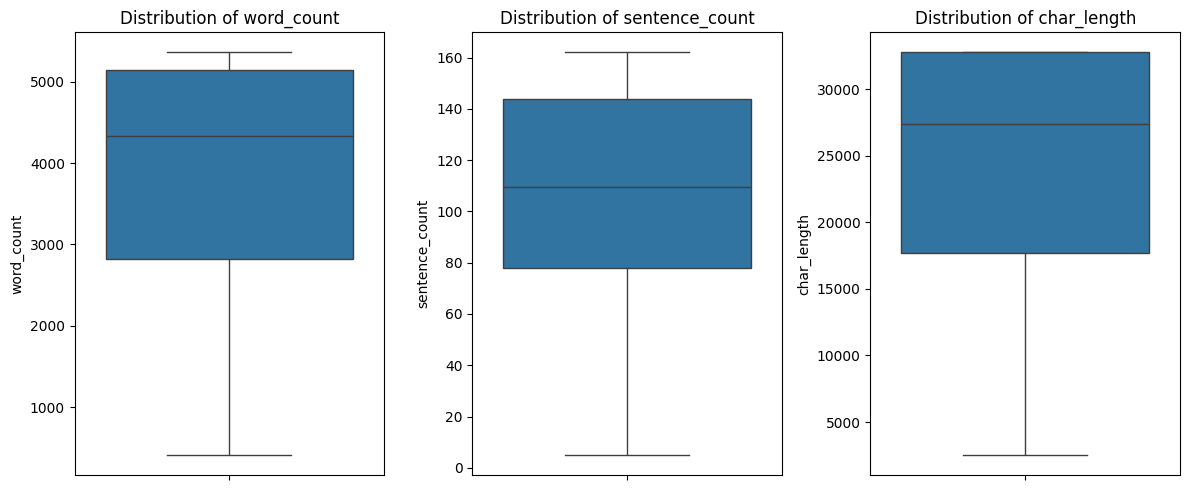

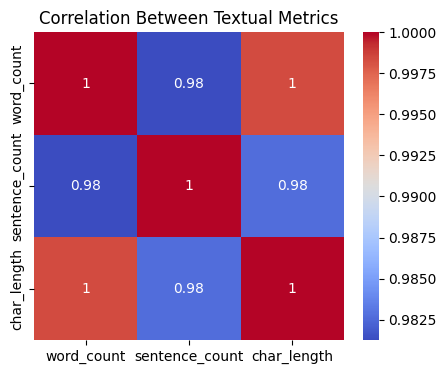

In [ ]:
import nltk
nltk.download('punkt_tab')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re

# If you haven't downloaded NLTK punkt before, uncomment this:
nltk.download('punkt')

# Let's assume your dataframe is named df and column is 'MDA'
df = pd.read_excel("aapl_filings_with_custom_sentiment.xlsx")

# Create new features for descriptive analysis
df['word_count'] = df['MDA'].apply(lambda x: len(str(x).split()))
df['sentence_count'] = df['MDA'].apply(lambda x: len(nltk.sent_tokenize(str(x))))
df['char_length'] = df['MDA'].apply(lambda x: len(str(x)))

# Display basic descriptive statistics for these new numeric columns
desc_stats = df[['word_count', 'sentence_count', 'char_length']].describe()
print(desc_stats)

# Visualize distributions
plt.figure(figsize=(12, 5))
for i, col in enumerate(['word_count', 'sentence_count', 'char_length'], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Optional: correlation between these textual metrics
corr = df[['word_count', 'sentence_count', 'char_length']].corr()
plt.figure(figsize=(5, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Between Textual Metrics')
plt.show()

creating the HISTOGRAM , BOX PLOT, BAR CHART

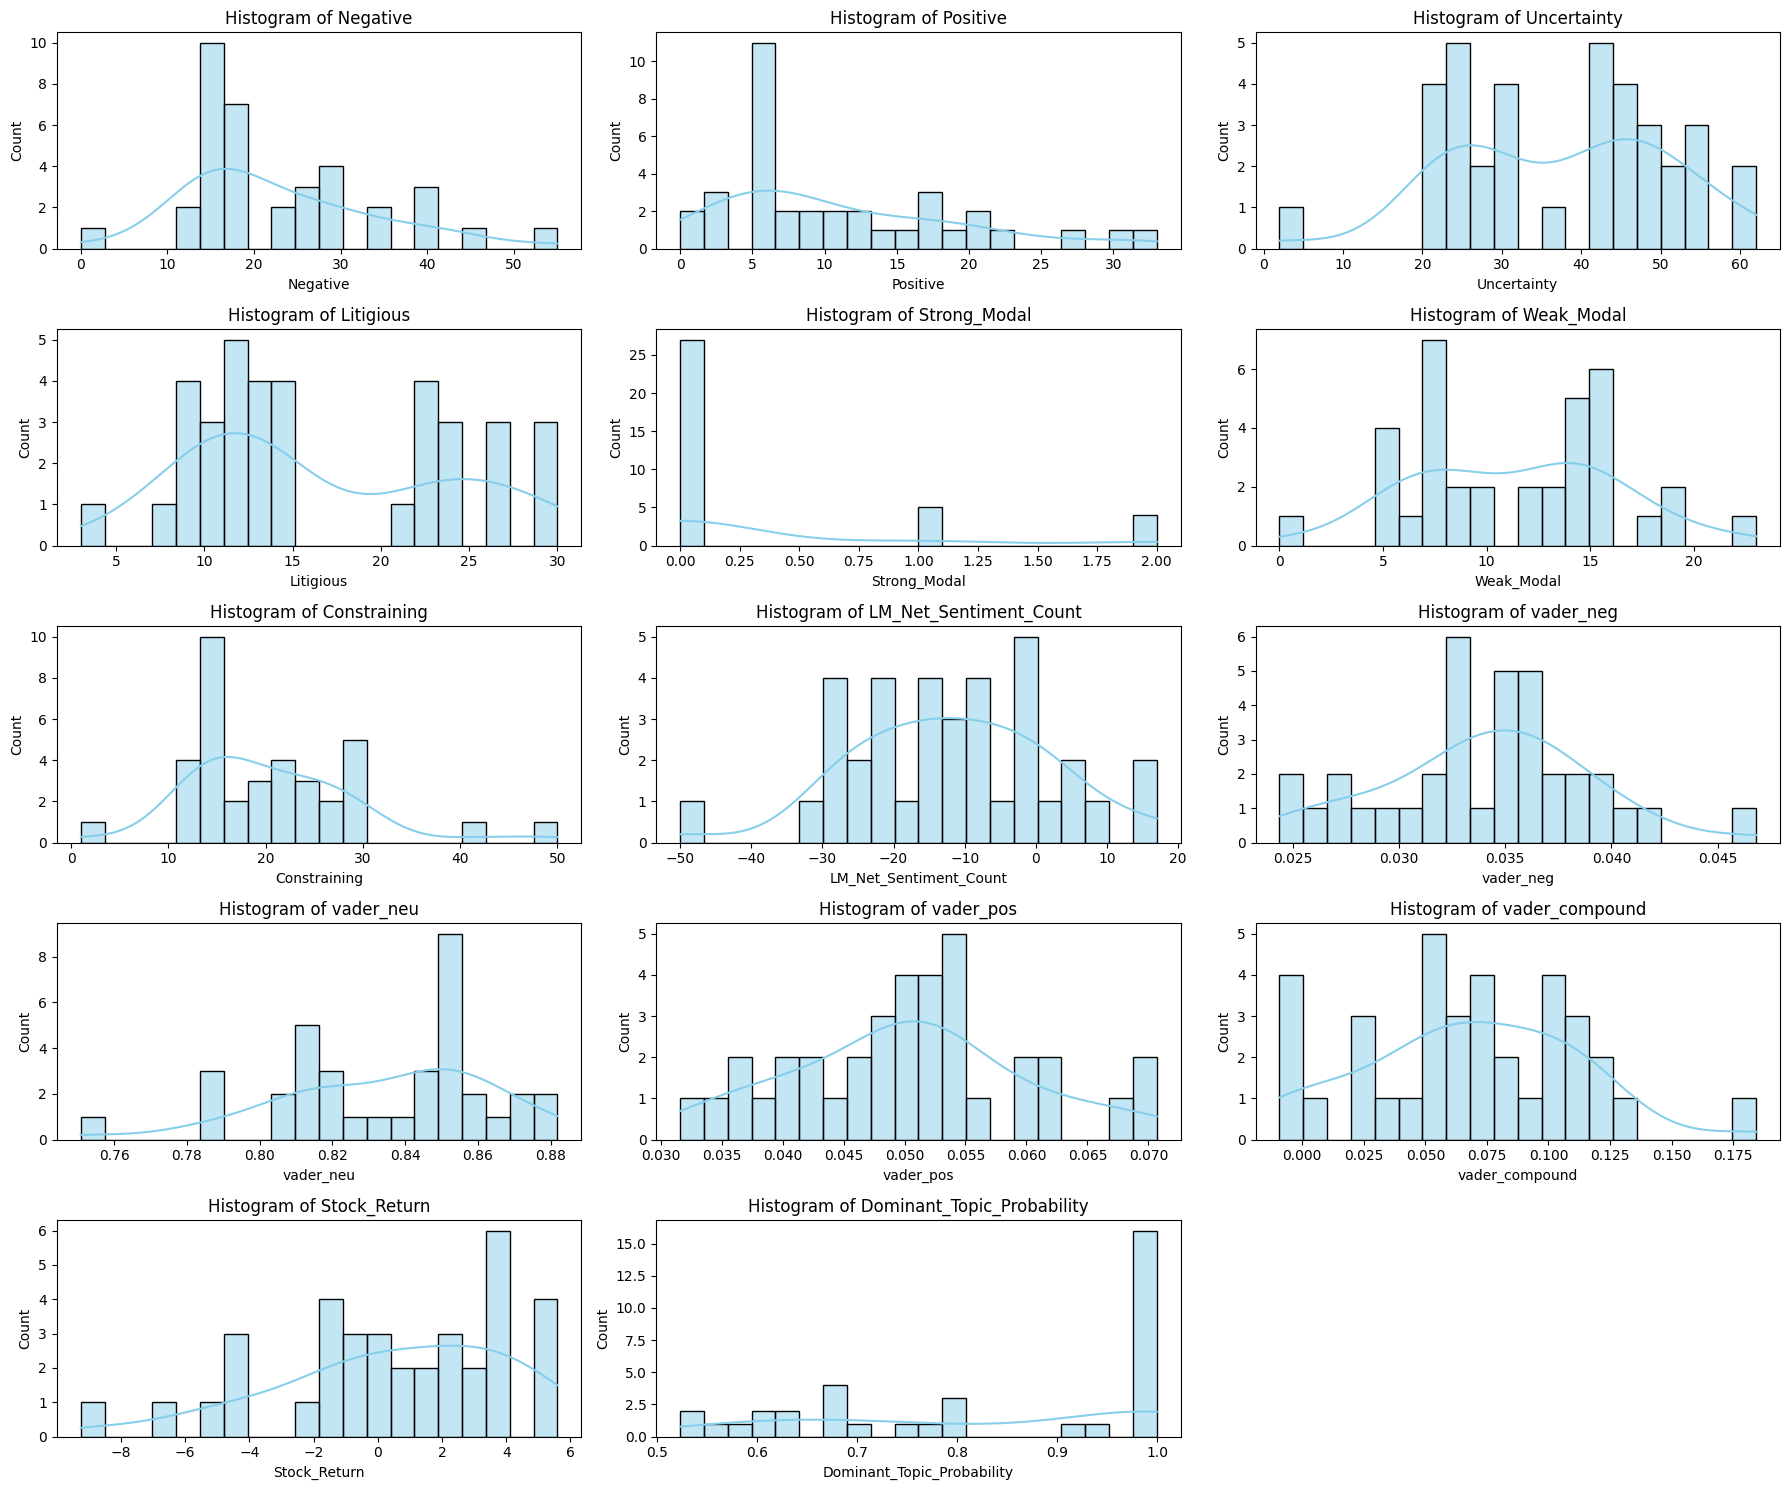

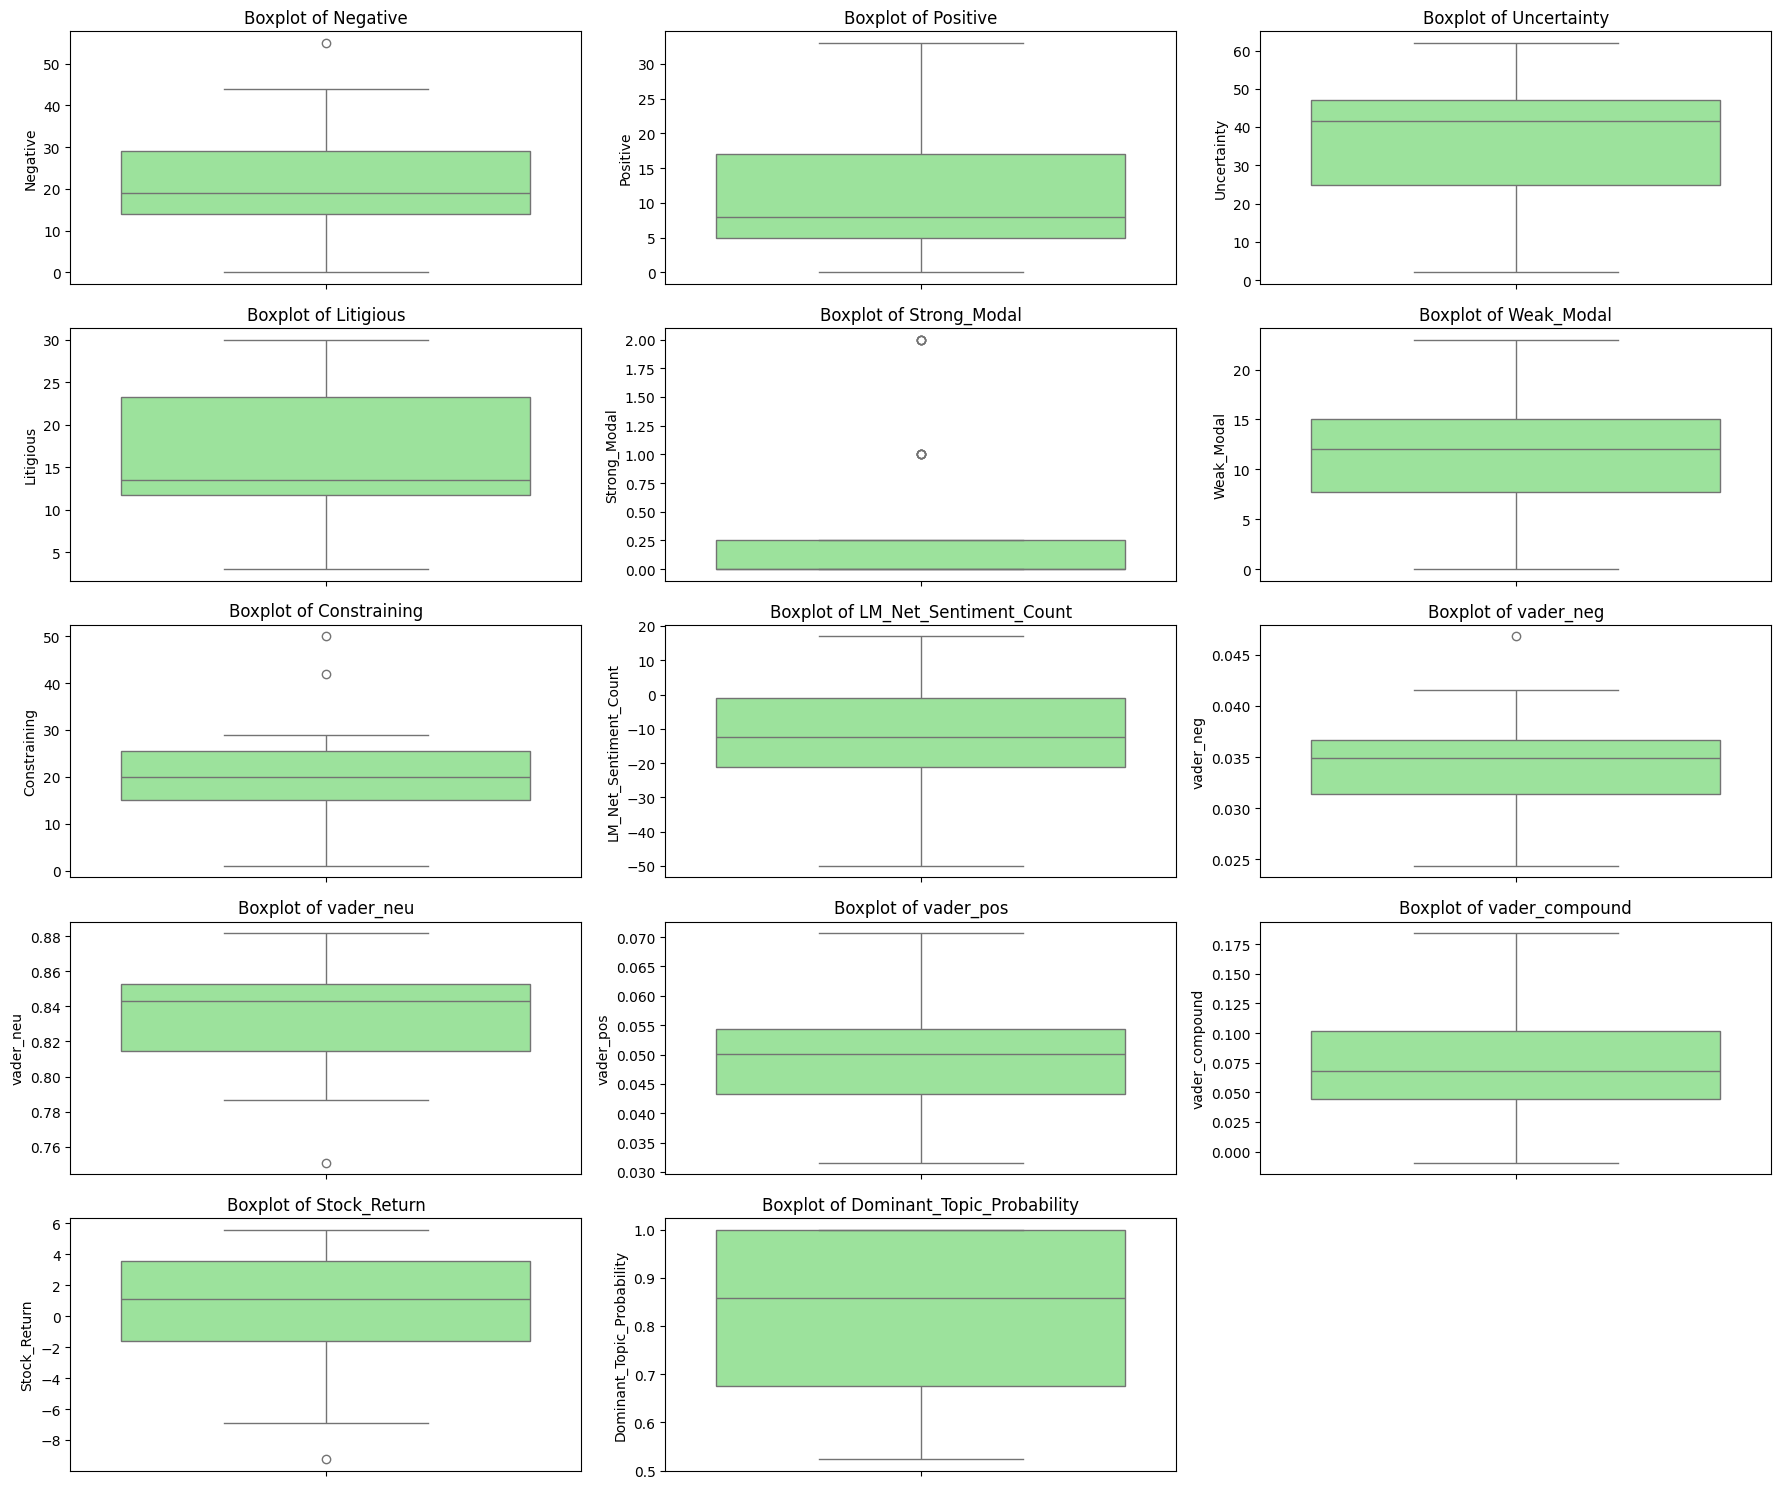

/tmp/ipython-input-3224876625.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.index, y=top_counts.values, palette="coolwarm")
/tmp/ipython-input-3224876625.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.index, y=top_counts.values, palette="coolwarm")
/tmp/ipython-input-3224876625.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.index, y=top_counts.values, palette="coolwarm")
/tmp/ipython-input-3224876625.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and w

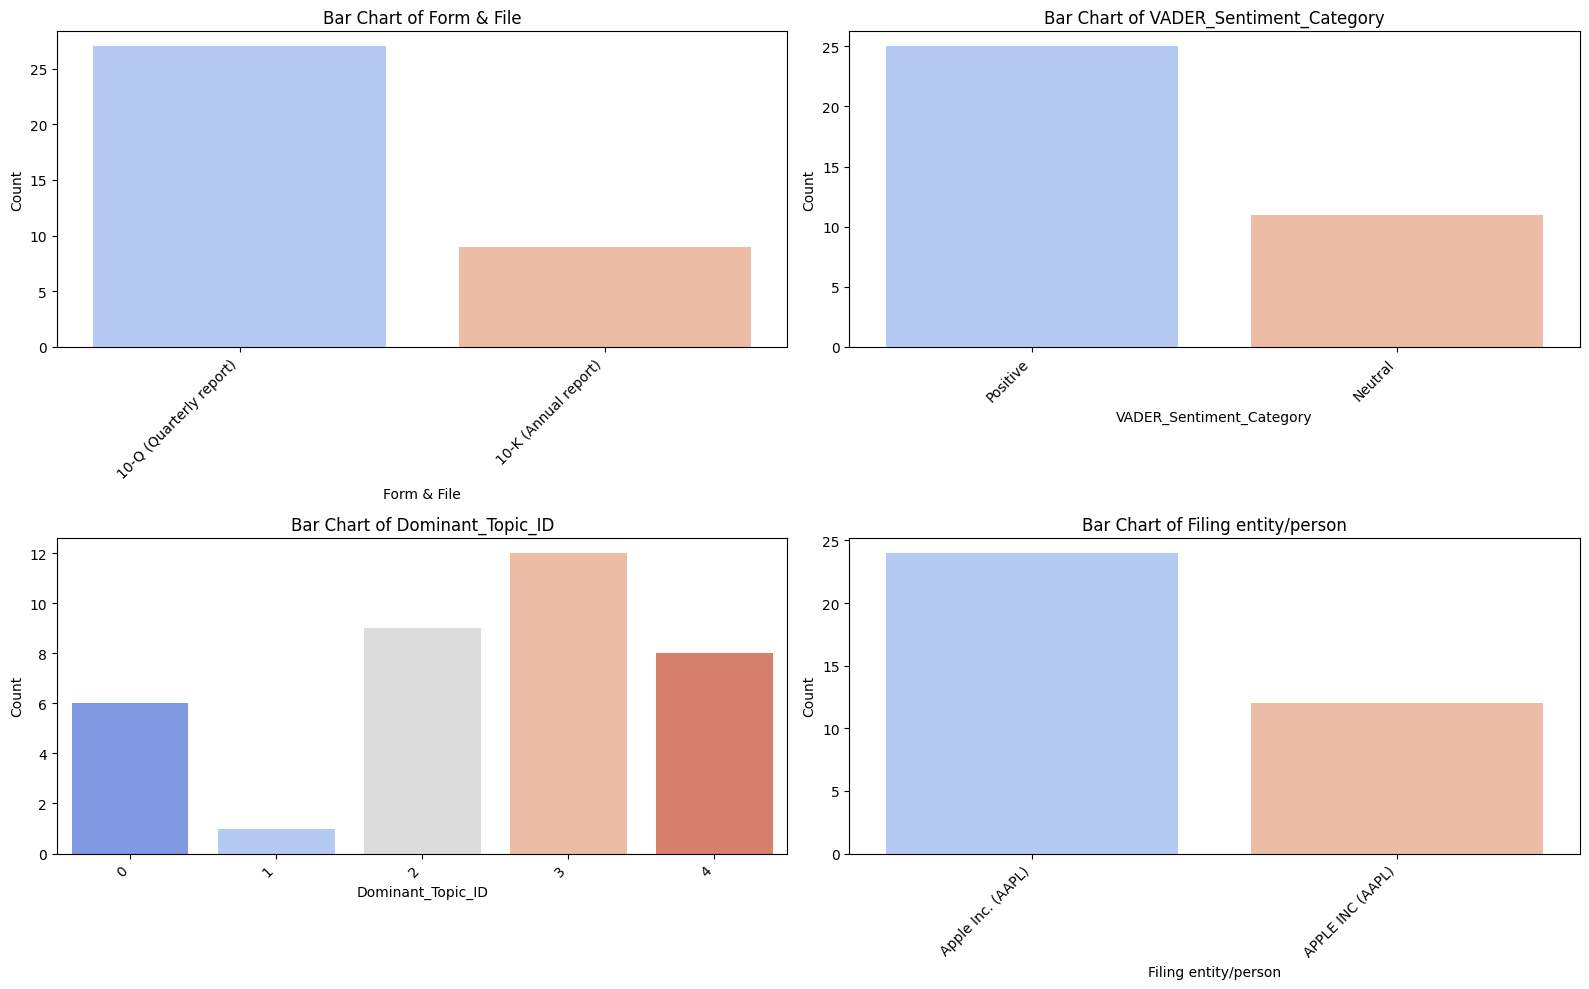

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assume your DataFrame is named df

# Separate numerical and categorical features
numeric_cols = ['Negative', 'Positive', 'Uncertainty', 'Litigious',
                'Strong_Modal', 'Weak_Modal', 'Constraining',
                'LM_Net_Sentiment_Count', 'vader_neg', 'vader_neu',
                'vader_pos', 'vader_compound', 'Stock_Return',
                'Dominant_Topic_Probability']

categorical_cols = ['Form & File', 'VADER_Sentiment_Category', 'Dominant_Topic_ID', 'Filing entity/person']

# ==============================
# 1️⃣ HISTOGRAMS for Numerical Columns
# ==============================
plt.figure(figsize=(18, 15))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(5, 3, i)
    sns.histplot(df[col], kde=True, bins=20, color='skyblue')
    plt.title(f'Histogram of {col}')
plt.tight_layout()
plt.show()

# ==============================
# 2️⃣ BOX PLOTS for Numerical Columns
# ==============================
plt.figure(figsize=(18, 15))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(5, 3, i)
    sns.boxplot(y=df[col], color='lightgreen')
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

# ==============================
# 3️⃣ BAR CHARTS for Categorical Columns
# ==============================
plt.figure(figsize=(16, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    top_counts = df[col].value_counts().head(10)
    sns.barplot(x=top_counts.index, y=top_counts.values, palette="coolwarm")
    plt.title(f'Bar Chart of {col}')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()


Study relationships between variables using scatter plots, heatmaps, and pairplots.

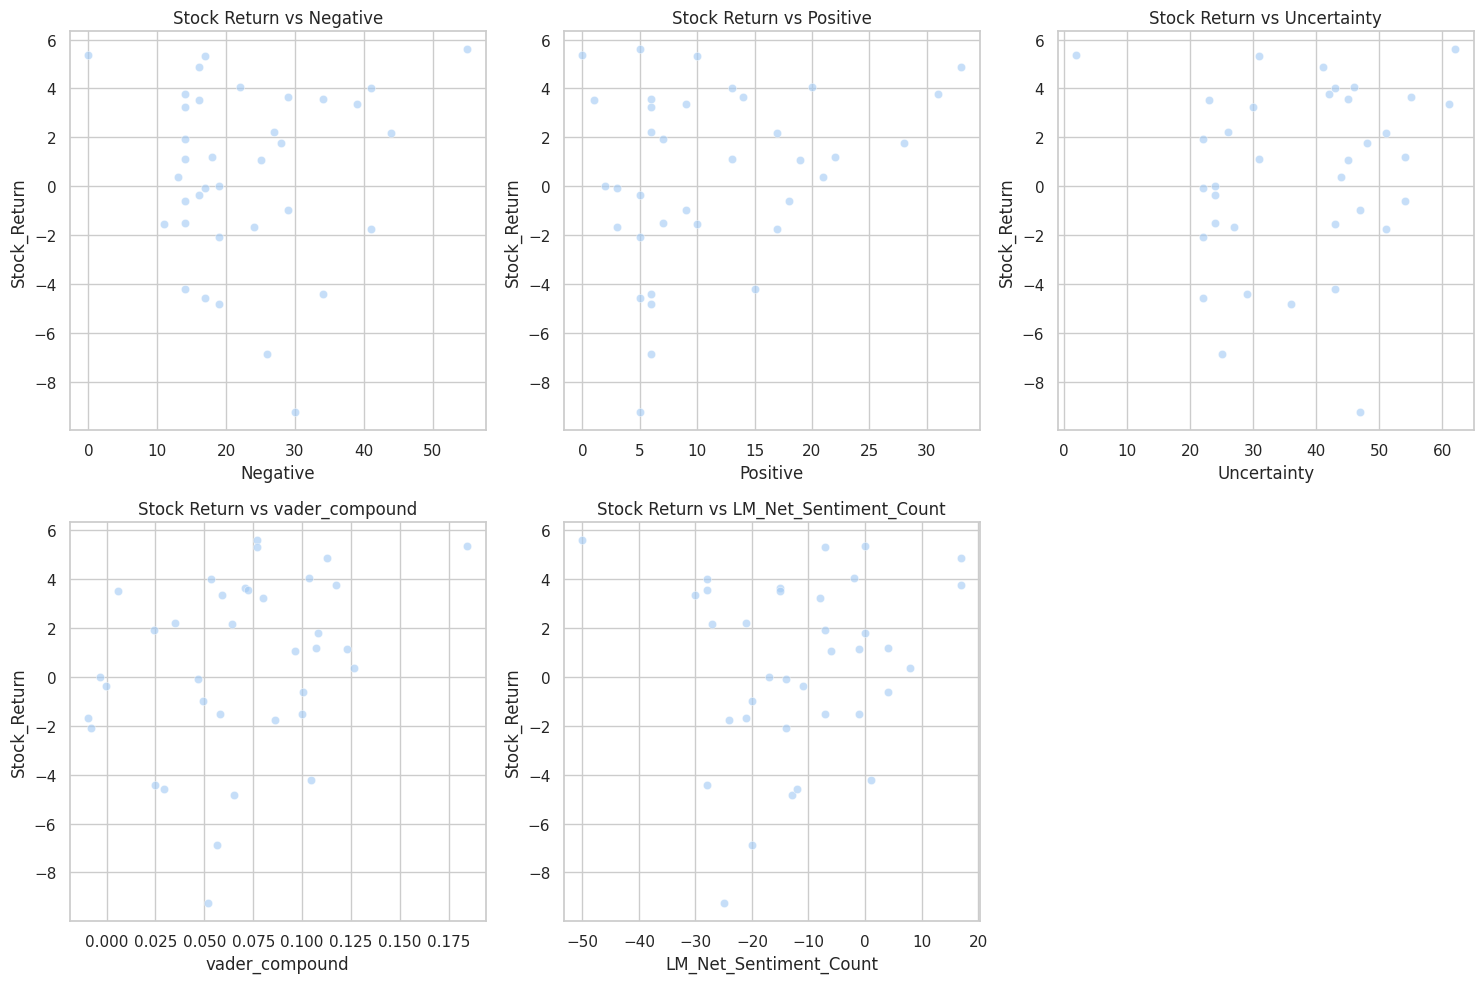

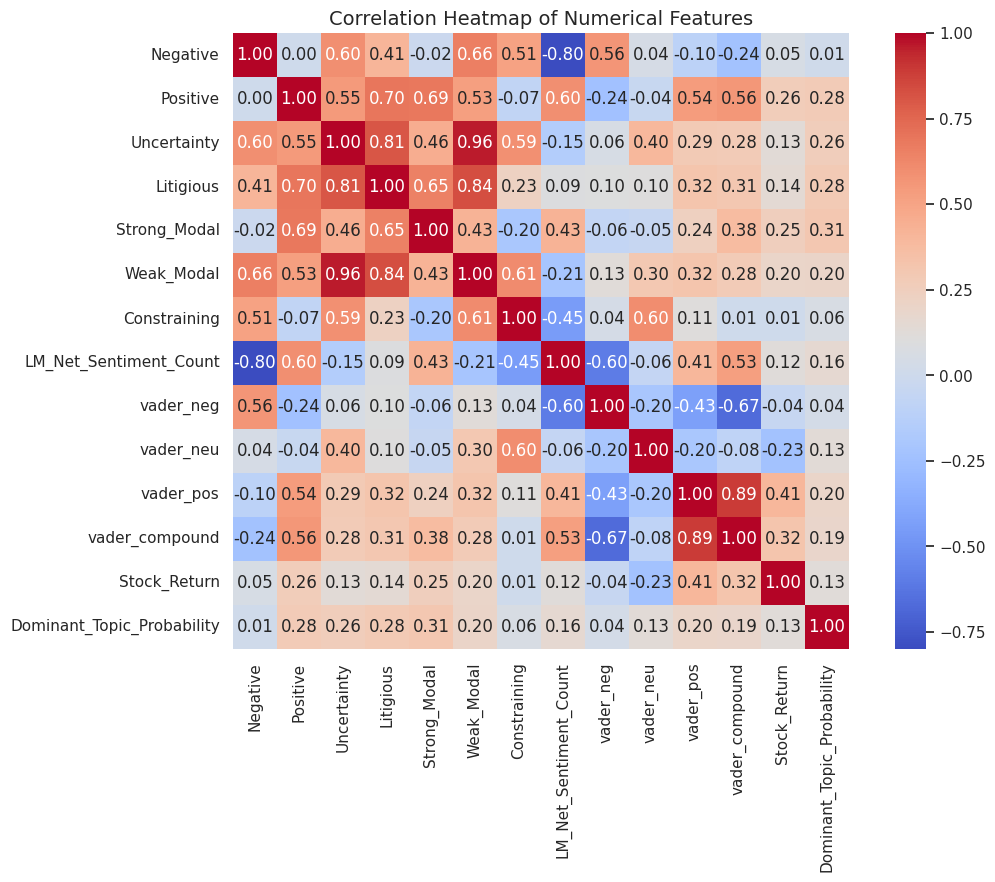

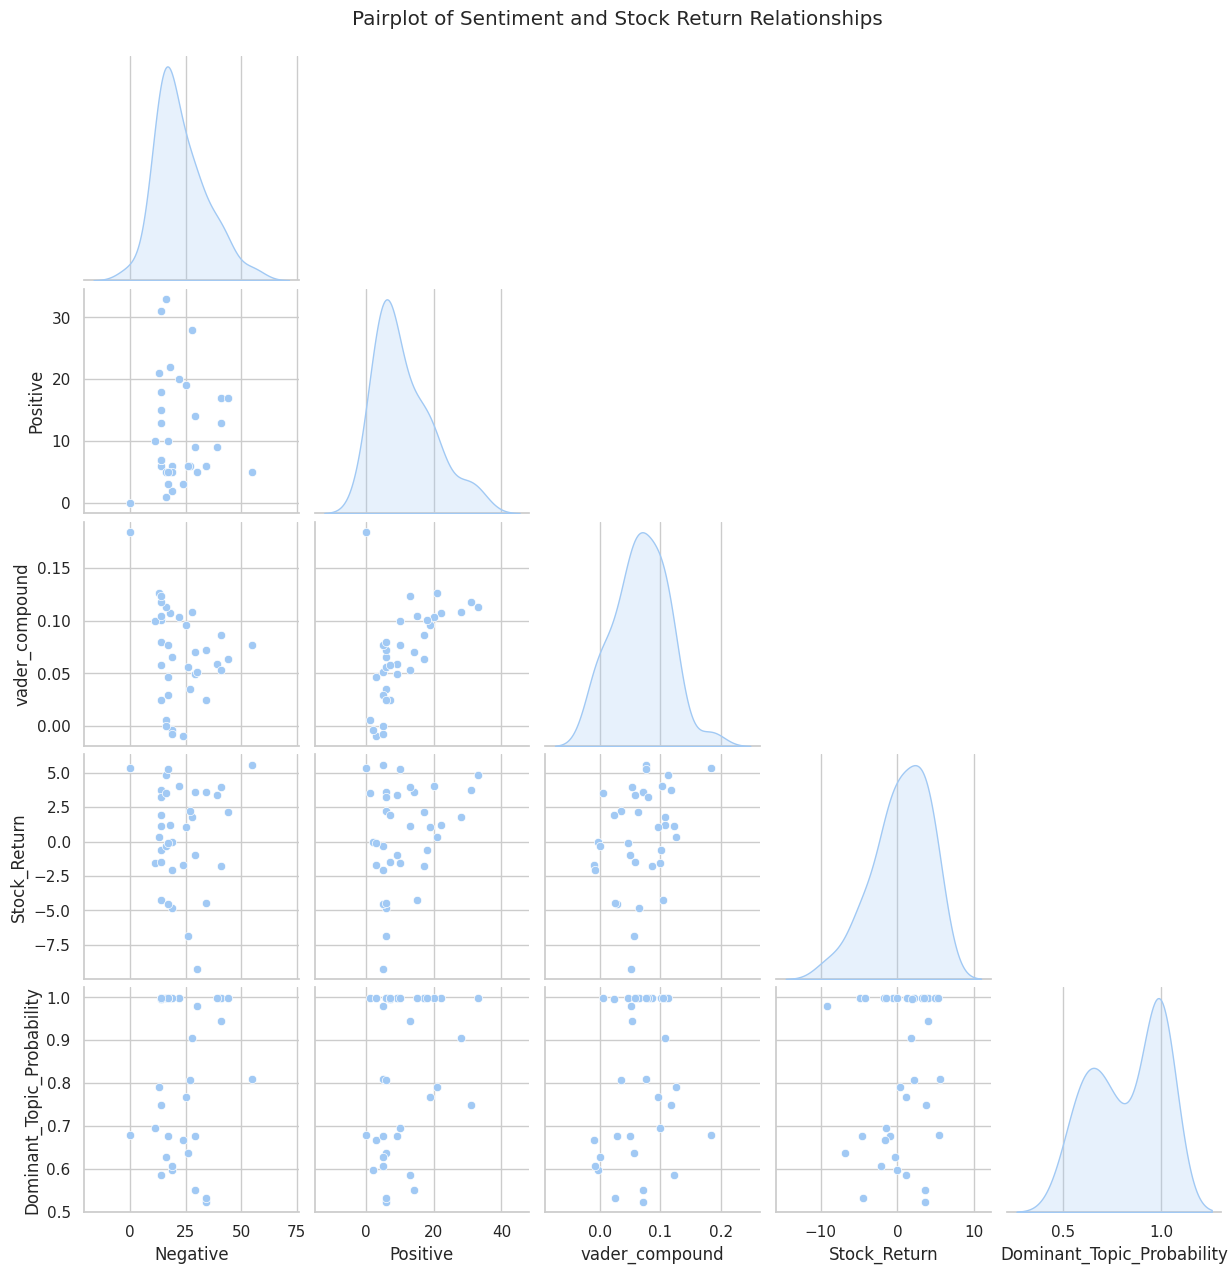

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="pastel")


# Scatter plots between Stock_Return and key sentiment metrics
sentiment_cols = ['Negative', 'Positive', 'Uncertainty', 'vader_compound', 'LM_Net_Sentiment_Count']

plt.figure(figsize=(15, 10))
for i, col in enumerate(sentiment_cols, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=df, x=col, y='Stock_Return', alpha=0.6)
    plt.title(f'Stock Return vs {col}')
plt.tight_layout()
plt.show()



# Select only numeric columns for correlation
num_cols = ['Negative', 'Positive', 'Uncertainty', 'Litigious',
            'Strong_Modal', 'Weak_Modal', 'Constraining',
            'LM_Net_Sentiment_Count', 'vader_neg', 'vader_neu',
            'vader_pos', 'vader_compound', 'Stock_Return',
            'Dominant_Topic_Probability']

# Compute correlation matrix
corr_matrix = df[num_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Heatmap of Numerical Features', fontsize=14)
plt.show()


# Select a few representative columns for clarity
pairplot_cols = ['Negative', 'Positive', 'vader_compound', 'Stock_Return', 'Dominant_Topic_Probability']

sns.pairplot(df[pairplot_cols], diag_kind='kde', corner=True)
plt.suptitle('Pairplot of Sentiment and Stock Return Relationships', y=1.02)
plt.show()


Bar and BoxPlot to show the outlier

Outlier count per feature:
                        Feature  Outlier_Count
0                     Negative              1
1                     Positive              0
2                  Uncertainty              0
3                    Litigious              0
4                 Strong_Modal              9
5                   Weak_Modal              0
6                 Constraining              2
7       LM_Net_Sentiment_Count              0
8                    vader_neg              1
9                    vader_neu              1
10                   vader_pos              0
11              vader_compound              0
12                Stock_Return              1
13  Dominant_Topic_Probability              0


/tmp/ipython-input-566401305.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=outlier_df, x='Feature', y='Outlier_Count', palette='coolwarm')


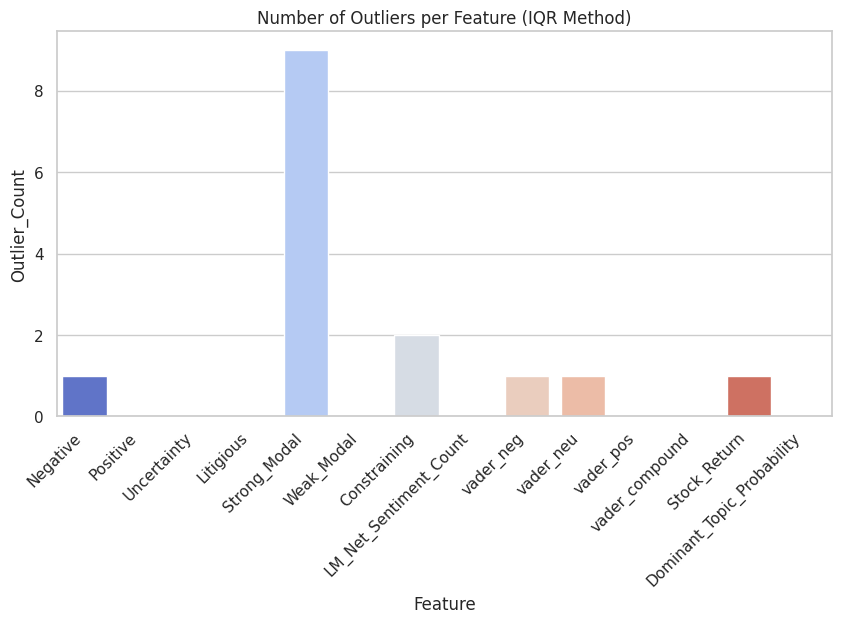

✅ Outliers handled successfully using IQR capping method.


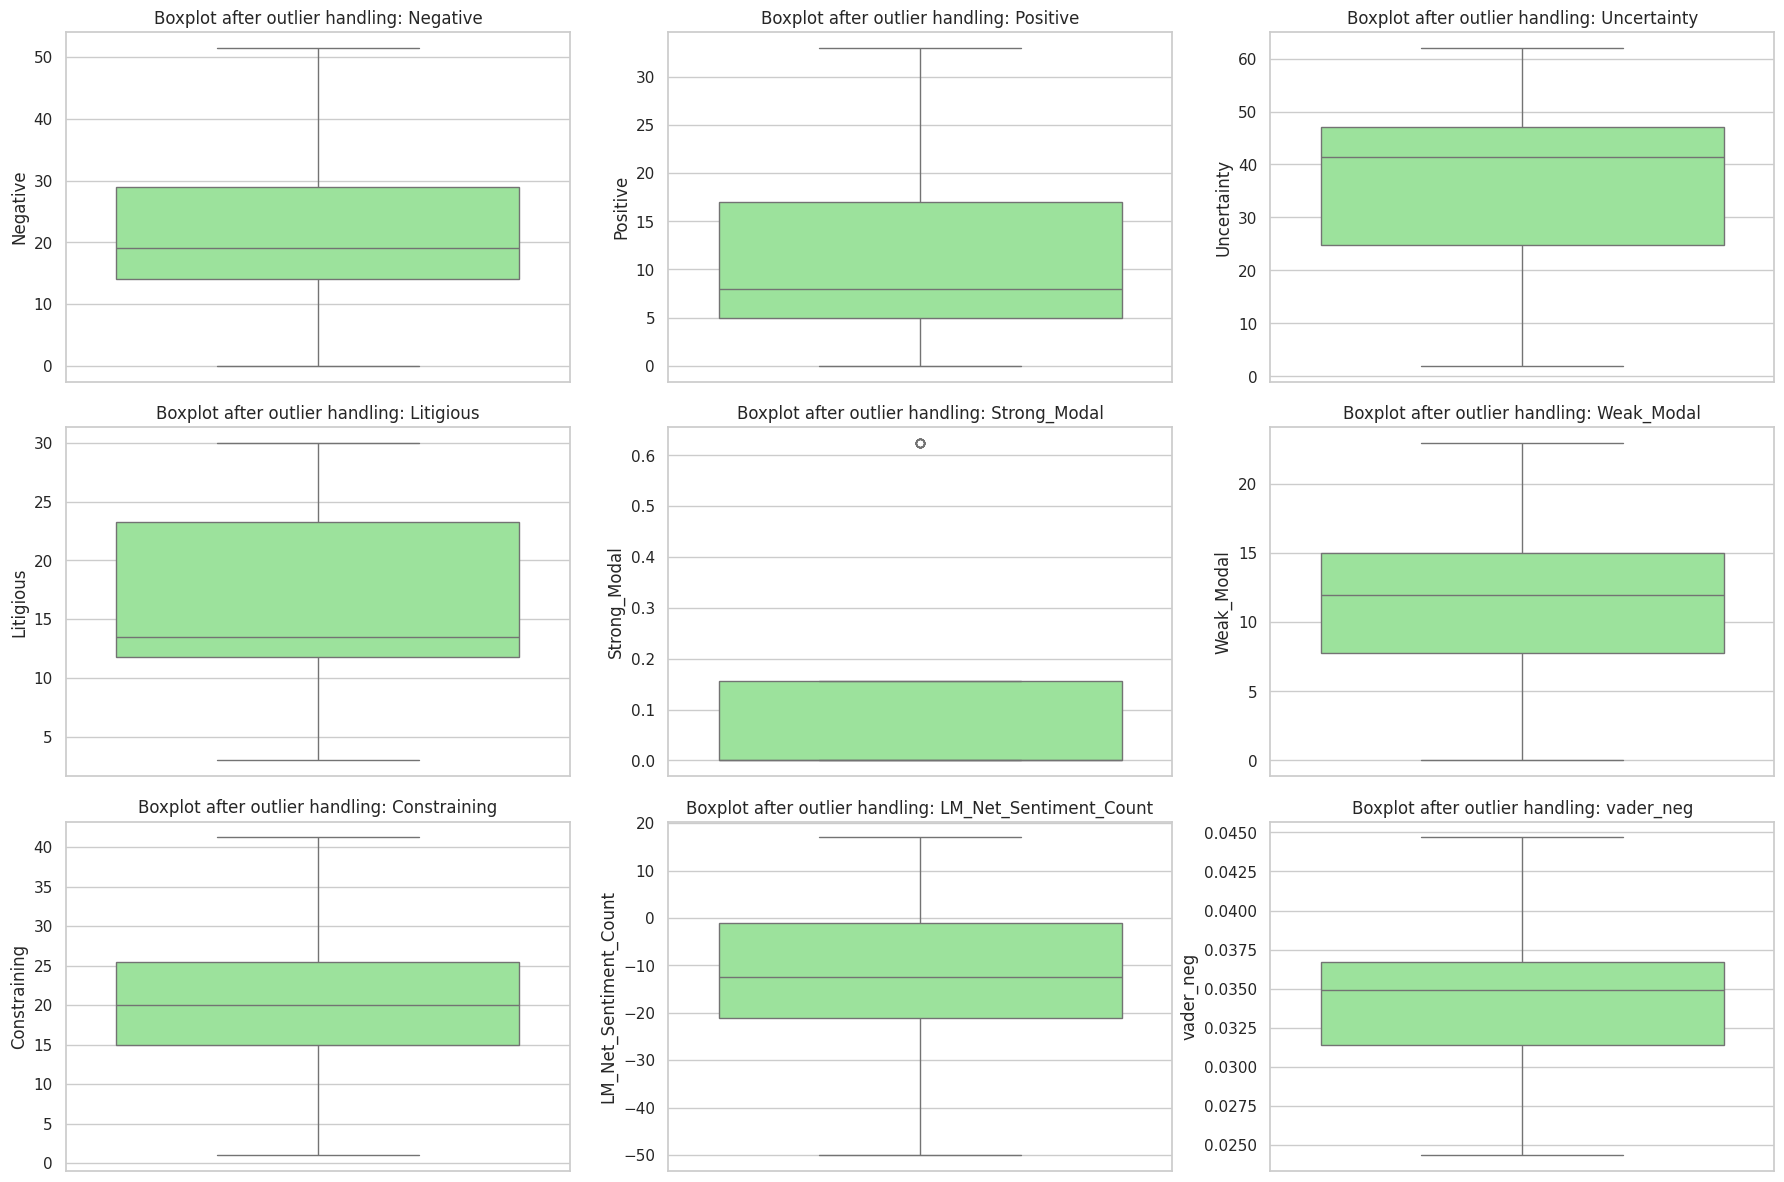

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
num_cols = ['Negative', 'Positive', 'Uncertainty', 'Litigious',
            'Strong_Modal', 'Weak_Modal', 'Constraining',
            'LM_Net_Sentiment_Count', 'vader_neg', 'vader_neu',
            'vader_pos', 'vader_compound', 'Stock_Return',
            'Dominant_Topic_Probability']

# Function to detect outliers using the IQR rule
def detect_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    return outliers

# Count number of outliers per column
outlier_summary = {}
for col in num_cols:
    outlier_summary[col] = len(detect_outliers_iqr(df, col))

outlier_df = pd.DataFrame(list(outlier_summary.items()), columns=['Feature', 'Outlier_Count'])
print("Outlier count per feature:\n", outlier_df)

# Visualize outlier counts
plt.figure(figsize=(10, 5))
sns.barplot(data=outlier_df, x='Feature', y='Outlier_Count', palette='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.title('Number of Outliers per Feature (IQR Method)')
plt.show()




# Function to cap outliers (Winsorization)
def cap_outliers(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[col] = np.where(data[col] < lower_bound, lower_bound,
                         np.where(data[col] > upper_bound, upper_bound, data[col]))
    return data

# Apply capping to all numeric features
for col in num_cols:
    df = cap_outliers(df, col)

print("✅ Outliers handled successfully using IQR capping method.")






# Replot boxplots after handling outliers
plt.figure(figsize=(18, 12))
for i, col in enumerate(num_cols[:9], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[col], color='lightgreen')
    plt.title(f'Boxplot after outlier handling: {col}')
plt.tight_layout()
plt.show()
